In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np

from keras.callbacks import ReduceLROnPlateau
from keras.models import Model, load_model
from keras.optimizers import SGD, Adam
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input, Conv2D, GlobalMaxPooling2D, MaxPooling2D, Flatten, Concatenate
from keras import layers as kl
# Conv2D, Input, Flatten, MaxPooling2D, UpSampling2D, concatenate, Cropping2D, Reshape, BatchNormalization

from keras.applications.nasnet import NASNetLarge

%matplotlib inline

Using TensorFlow backend.


In [3]:
from utils.preprocess import DataGenerator
from utils.callbacks import PlotCurves
from utils.load_data import load_data
from utils.comparams import calculate_auc, auc

In [4]:
import tensorflow as tf
import keras.callbacks
from keras import backend as K
config = tf.ConfigProto(intra_op_parallelism_threads=31, inter_op_parallelism_threads=1, allow_soft_placement=True)
session = tf.Session(config=config)
K.set_session(session)
os.environ["OMP_NUM_THREADS"] = "31"
os.environ["KMP_BLOCKTIME"] = "1"
os.environ["KMP_SETTINGS"] = "1"
os.environ["KMP_AFFINITY"]= "granularity=fine,verbose,compact,1,0"

### Data Generator

In [5]:
data_dir = './data/'

In [6]:
x_train, y_train, x_valid, y_valid = load_data(data_dir, purpose='train', 
                                               limit=None, val_limit=None, norm='macenko')
len(x_train), len(x_valid)

(261756, 32728)

In [7]:
# indexes
train_id = np.arange(len(x_train))
val_id = np.arange(len(x_valid))

# create a useful dictionary structures
partition = {}
partition['train'] = train_id
partition['validation'] = val_id
    
train_labels = {str(i) : y_train[i].flatten()[0] for i in train_id}
val_labels = {str(i) : y_valid[i].flatten()[0] for i in val_id}

In [8]:
del train_id
del val_id
del data_dir

## MODEL

In [9]:
def build_arch_10_net():
    
    inputs = Input((96, 96, 3))
    nasnet = NASNetLarge(input_tensor=inputs, weights='imagenet', include_top=False)
    x = nasnet.output
    x = Conv2D(32, (1,1), activation='relu')(x)
    x = GlobalAveragePooling2D()(x)
    x = Dense(64, activation='relu')(x)
    y = Dense(2, activation='softmax')(x)
    
    # Train only the top layer
    for layer in nasnet.layers:
        layer.trainable = False

    model = Model(inputs=inputs, outputs=y)

    return model

In [10]:
model = build_arch_10_net()

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 96, 96, 3)         0         
_________________________________________________________________
NASNet (Model)               multiple                  84916818  
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 3, 3, 32)          129056    
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 130       
Total params: 85,048,116
Trainable params: 131,298
Non-trainable params: 84,916,818
__________________________________________________________

### Compile

In [12]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2,
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.000005)

In [13]:
optimizer = Adam(lr=0.001)
loss = 'binary_crossentropy'
metrics = ['acc', auc]

In [14]:
model.compile(optimizer, loss, metrics)

## Train the model

In [16]:
model_name = 'nasnet_model_bin_cross_arch_10_lr_0_001_inp96'

In [17]:
batch_size = 128
n_epoch = 10

# Parameters for generators
train_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': True,
    'shuffle': True
}

val_params = {
    'dim': (96, 96),
    'batch_size': batch_size,
    'n_classes': 2,
    'aug': False,
    'shuffle': True
}

# Generators
training_generator = DataGenerator(partition['train'], x_train, train_labels, **train_params)
validation_generator = DataGenerator(partition['validation'], x_valid, val_labels, **val_params)

In [ ]:
# Callbacks
callbacks = [PlotCurves(model_name=model_name, weights2pickle=True), learning_rate_reduction]

In [ ]:
del x_train
del x_valid
del y_train
del y_valid
del train_labels
del val_labels

In [ ]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)

Epoch 1/10
1911/2044 [===========================>..] - ETA: 6:31 - loss: 0.5675 - acc: 0.6943 - auc: 0.7472

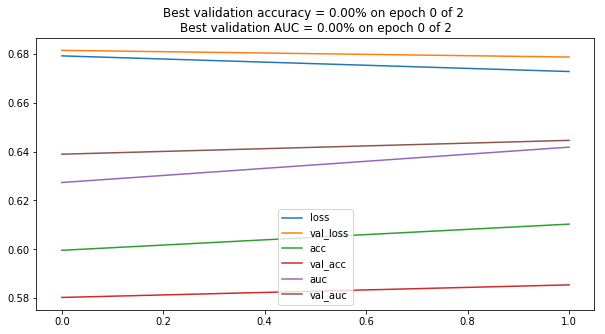

2044/2044 [==============================] - 6634s 3s/step - loss: 0.6728 - acc: 0.6103 - auc: 0.6418 - val_loss: 0.6787 - val_acc: 0.5854 - val_auc: 0.6446
Epoch 3/10
1301/2044 [==================>...........] - ETA: 35:44 - loss: 0.6722 - acc: 0.6120 - auc: 0.6454

In [ ]:
# Training with learning 
model.fit_generator(training_generator, validation_data=validation_generator, 
                    epochs=n_epoch, callbacks=callbacks)